# Reto de Clasificación de Imágenes de Animales | Ruta N

## Contexto del reto a resolver

## Creación del ambiente virtual e instalación de dependencias

Lo primero es tener instalado Anaconda o Miniconda. Luego de eso abrir el terminal y crear un entorno virtual con la siguiente línea.

In [ ]:
%conda create -n RutaN python=3.9

Lo siguiente es activar el entorno virtual creado y luego instalar unas dependencias de NVidia para poder utilizar la GPU en el entrenamiento de los modelos.

In [ ]:
%conda activate RutaN
%conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

A continuación se instalan todas las dependencias necesarias.

In [8]:
%pip install tensorflow==2.10 numpy matplotlib pillow scipy

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/e9/20/2d0561ab54d857365926c5b53538369a7b8d6ccbffaca509305b074028cd/scipy-1.11.2-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/59.1 kB ? eta -:--:--
     ------------- ------------------------ 20.5/59.1 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 59.1/59.1 kB 626.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/44.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/44.1 MB 3.2 MB/s eta 0:00:14
   ---------------------------------------- 0.2/44.1 MB 2.4 MB/s eta 0:00:19
   ---------------------------------------- 0.3/44.1 MB 2.6 MB/s eta 0:00:17
   ---------------------------------------- 0.5/44.1 MB 2.8 MB/s eta 0:00:16
    --------------------------------------- 0.7/44.1 MB 2.9 MB/s eta 0:00:15
    --------------------------------------- 0.8/44.1 MB 3.0 MB/s eta 0:00:15
    -----------------------------

Por último, se exporta a un archivo de texto las dependencias utilizadas para facilitar la instalación en el futuro.

In [ ]:
%pip freeze > requirements.txt

## Importación de paquetes

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Trabajando con el dataset

Lo que haremos será crear una función para distribuir aleatoriamente las imágenes de las 5 clases en 3 carpetas: train, test y validation. Para la carpeta de train destinaremos el 70% de las imágenes; para validation el 10% y para test el 20% restante.

In [9]:
import os
import random
import shutil

def distribuir_imagenes(carpeta_imagenes, carpetas_destino, proporciones, semilla = None):
    """
    Distribuye copias aleatorias de imágenes desde una carpeta de origen a varias carpetas de destino
    según las proporciones especificadas.

    Args:
        carpeta_imagenes (str): Ruta de la carpeta que contiene las imágenes.
        carpetas_destino (list of str): Lista de rutas de las carpetas de destino.
        proporciones (list of int): Lista de proporciones para cada carpeta de destino en porcentaje.
        semilla (int): Semilla para el generador de números aleatorios (opcional).
    """
    if sum(proporciones) != 100:
        raise ValueError("Las proporciones deben sumar 100.")

    if semilla is not None:
        random.seed(semilla)

    archivos = os.listdir(carpeta_imagenes)
    total_archivos = 5200

    for i, carpeta_destino in enumerate(carpetas_destino):
        cantidad_archivos = total_archivos * proporciones[i] // 100

        # Crear la carpeta de destino si no existe
        os.makedirs(carpeta_destino, exist_ok=True)

        for _ in range(cantidad_archivos):
            archivo = random.choice(archivos)
            origen = os.path.join(carpeta_imagenes, archivo)
            destino = os.path.join(carpeta_destino, archivo)
            shutil.copy(origen, destino)

    print("Distribución de copias de imágenes completada.")

Comenzamos con las imágenes de los pájaros.

In [10]:

carpeta_imagenes = r"raw_dataset\birds"
carpetas_destino = [r"dataset\train\birds", r"dataset\test\birds", r"dataset\validation\birds"]
proporciones = [70, 20, 10]
semilla = 42
distribuir_imagenes(carpeta_imagenes, carpetas_destino, proporciones, semilla = semilla)

Distribución de copias de imágenes completada.


Continuamos con los gatos.

In [11]:
carpeta_imagenes = r"raw_dataset\cat"
carpetas_destino = [r"dataset\train\cat", r"dataset\test\cat", r"dataset\validation\cat"]
proporciones = [70, 20, 10]
semilla = 42
distribuir_imagenes(carpeta_imagenes, carpetas_destino, proporciones, semilla = semilla)

Distribución de copias de imágenes completada.


Los siguientes son los perros.

In [12]:
carpeta_imagenes = r"raw_dataset\dog"
carpetas_destino = [r"dataset\train\dog", r"dataset\test\dog", r"dataset\validation\dog"]
proporciones = [70, 20, 10]
semilla = 42
distribuir_imagenes(carpeta_imagenes, carpetas_destino, proporciones, semilla = semilla)

Distribución de copias de imágenes completada.


Ahora los peces.

In [13]:
carpeta_imagenes = r"raw_dataset\fish"
carpetas_destino = [r"dataset\train\fish", r"dataset\test\fish", r"dataset\validation\fish"]
proporciones = [70, 20, 10]
semilla = 42
distribuir_imagenes(carpeta_imagenes, carpetas_destino, proporciones, semilla = semilla)

Distribución de copias de imágenes completada.


Y por último los salvajes.

In [14]:
carpeta_imagenes = r"raw_dataset\wild"
carpetas_destino = [r"dataset\train\wild", r"dataset\test\wild", r"dataset\validation\wild"]
proporciones = [70, 20, 10]
semilla = 42
distribuir_imagenes(carpeta_imagenes, carpetas_destino, proporciones, semilla = semilla)

Distribución de copias de imágenes completada.


## Preprocesamiento de las imágenes

### Data Augmentation

In [11]:
# Creamos un generador de imágenes para Training
trainImgGen = ImageDataGenerator(
    # Escalar los valores de las imágenes para que vayan entre 0 y 1
    rescale = 1. / 255,
    # Rotación de 40°
    rotation_range = 40,
    # Movimiento horizontal
    width_shift_range = 0.6,
    # Movimiento vertical
    height_shift_range = 0.35,
    # Cortar
    shear_range = 0.2,
    # Zoom
    zoom_range = 0.2,
    # Rotación horizontal
    horizontal_flip = True,
    # Rotación vertical
    vertical_flip = True,
    # Rellenar los espacios vacíos de la imagen al momento de transformarla
    fill_mode = "nearest",
    # Cambiar el brillo
    brightness_range = [0.4, 1.5]
)

# Creamos un generador de imágenes para Test y Validation simplemente escalando los valores para que vayan de 0 a 1
testDataGen = ImageDataGenerator(rescale = 1. / 255)

In [12]:
# Generamos imágenes para training cargándolas de un directorio
trainGenerator = trainImgGen.flow_from_directory(r"dataset/train",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 64 imágenes
    batch_size = 64,
    # Clasificación múltiples
    class_mode = "categorical"
)

# Generamos imágenes para validation cargándolas de un directorio y solamente reescalándolas
validationGenerator = testDataGen.flow_from_directory(r"dataset/validation",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 64 imágenes
    batch_size = 64,
    # Clasificación múltiples
    class_mode = "categorical"
)

# Generamos imágenes para testing cargándolas de un directorio y solamente reescalándolas
testGenerator = testDataGen.flow_from_directory(r"dataset/test",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 64 imágenes
    batch_size = 64,
    # Clasificación múltiples
    class_mode = "categorical"
)

Found 13863 images belonging to 5 classes.
Found 2509 images belonging to 5 classes.
Found 4754 images belonging to 5 classes.


## Creación del Modelo

### Callbacks

In [14]:
checkpoint = ModelCheckpoint(
    # Nombre del archivo. La extensión hdf5 es usada para guardar los pesos del modelo
    filepath = f"rutan_classification_{str(datetime.date.today())}.hdf5",
    verbose = 1,
    # Métrica que queremos monitorear
    monitor = "val_accuracy",
    # Solo guardar los mejores pesos
    save_best_only = True
)

### Definición de la arquitectura

In [15]:
# Creamos un modelo secuencial
model = Sequential()

"""
Capa de entrada
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 32 kernels
        filters = 32, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
        # Datos de entrada de 128 pixeles con 3 canales
        input_shape = (128, 128, 3)
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))

"""
Capa de convolución 2
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 64 kernels
        filters = 64, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.2
model.add(Dropout(0.2))

"""
Capa de convolución 3
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 128 kernels
        filters = 128, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.3
model.add(Dropout(0.3))

"""
Capa de convolución 4
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 128 kernels
        filters = 128, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.4
model.add(Dropout(0.4))

"""
Capa de salida
"""
# Agregamos una capa Flatten para aplanar los datos y que queden en una sola dimensión
model.add(Flatten())
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.5
model.add(Dropout(0.5))
# Agregamos una capa Densa con 512 neuronas y activación ReLu
model.add(Dense(512, activation = "relu"))
# Agregamos la capa encargada de la clasificación múltiple con activación Softmax
model.add(Dense(5, activation = "softmax"))

# Resumen del modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                      

### Compilación del modelo

In [16]:
model.compile(
    # Función de pérdida Categorical Cross Entropy
    loss = "categorical_crossentropy",
    # Como optimizador utilizamos Adam que combina las bondades de AdaGrad y RMSProp
    optimizer = optimizers.Adam(),
    # Como métrica utilizamos el Accuracy Score
    metrics = "accuracy"
)

## Entrenamiento del modelo

In [20]:
# Entrenamos el modelo con nuestro Data Generator
hist = model.fit(
    # Utiliza las imágenes generadas por el Train Generator
    trainGenerator,
    # Utilizar los callbacks que creamos
    callbacks = [checkpoint],
    # Pasos por épocas igual a la cantidad de imágenes para training divido el tamaño de los batches
    steps_per_epoch = 2600 // 64,
    # Entrenamos por 80 épocas
    epochs = 80,
    # Para validación utilizamos las imágenes generadas por el Validation Generator
    validation_data = validationGenerator,
    # Pasos para validación igual a la cantidad de imágenes para testing divido el tamaño de los batches
    validation_steps = 930 // 64,
    verbose = 2,
    # Mezclar los datos
    shuffle = True
)

Epoch 1/80

Epoch 1: val_accuracy did not improve from 0.83371
40/40 - 12s - loss: 0.6018 - accuracy: 0.7822 - val_loss: 1.1423 - val_accuracy: 0.6763 - 12s/epoch - 297ms/step
Epoch 2/80

Epoch 2: val_accuracy did not improve from 0.83371
40/40 - 12s - loss: 0.6270 - accuracy: 0.7625 - val_loss: 0.8054 - val_accuracy: 0.7455 - 12s/epoch - 292ms/step
Epoch 3/80

Epoch 3: val_accuracy did not improve from 0.83371
40/40 - 11s - loss: 0.5499 - accuracy: 0.7957 - val_loss: 0.4810 - val_accuracy: 0.8337 - 11s/epoch - 276ms/step
Epoch 4/80

Epoch 4: val_accuracy did not improve from 0.83371
40/40 - 11s - loss: 0.5693 - accuracy: 0.7812 - val_loss: 0.4882 - val_accuracy: 0.8002 - 11s/epoch - 273ms/step
Epoch 5/80

Epoch 5: val_accuracy did not improve from 0.83371
40/40 - 11s - loss: 0.5519 - accuracy: 0.7984 - val_loss: 1.0917 - val_accuracy: 0.6730 - 11s/epoch - 272ms/step
Epoch 6/80

Epoch 6: val_accuracy did not improve from 0.83371
40/40 - 11s - loss: 0.5818 - accuracy: 0.7949 - val_loss:

## Evaluación del modelo

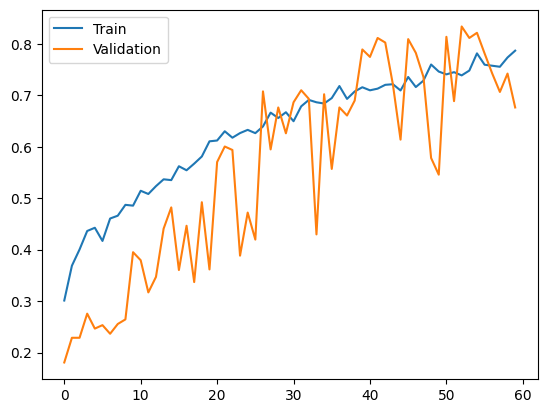

In [18]:
plt.plot(hist.history["accuracy"], label = "Train")
plt.plot(hist.history["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

In [19]:
model.evaluate(testGenerator)

75/75 [==============================] - 54s 728ms/step - loss: 0.9970 - accuracy: 0.6950


[0.9970118999481201, 0.6949936747550964]

In [4]:
postModel = load_model(r"rutan_classification_2023-09-05.hdf5")
postModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                      

In [10]:
postModel.evaluate(testGenerator)

149/149 [==============================] - 69s 460ms/step - loss: 0.2127 - accuracy: 0.9327


[0.21273015439510345, 0.9326882362365723]

In [3]:
clases = ["Pájaro", "Gato", "Perro", "Pez", "Salvaje"]

In [11]:
imagen = load_img('bird.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = postModel.predict(imagen)
print(prediccion)
clases[np.argmax(prediccion)]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step
[[8.8443887e-01 1.0047092e-02 1.8519139e-02 8.6256318e-02 7.3864550e-04]]


'Pájaro'

In [12]:
imagen = load_img('cat.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = postModel.predict(imagen)
print(prediccion)
clases[np.argmax(prediccion)]

1/1 [==============================] - 0s 15ms/step
[[0.36891627 0.3604884  0.0599071  0.2082407  0.00244749]]


'Pájaro'

In [13]:
imagen = load_img('dog.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = postModel.predict(imagen)
print(prediccion)
clases[np.argmax(prediccion)]

1/1 [==============================] - 0s 19ms/step
[[5.9718508e-03 2.0424721e-03 9.6032280e-01 2.1543949e-04 3.1447407e-02]]


'Perro'

In [14]:
imagen = load_img('fish.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = postModel.predict(imagen)
print(prediccion)
clases[np.argmax(prediccion)]

1/1 [==============================] - 0s 18ms/step


[[0.8226355  0.04948292 0.08980748 0.03715308 0.00092107]]


'Pájaro'

In [15]:
imagen = load_img('wild.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = postModel.predict(imagen)
print(prediccion)
clases[np.argmax(prediccion)]

1/1 [==============================] - 0s 17ms/step
[[0.13701811 0.02406658 0.35412067 0.00887014 0.47592443]]


'Salvaje'

## Segundo modelo propuesto

In [18]:
# Creamos un generador de imágenes para Training
trainImgGen = ImageDataGenerator(
    # Escalar los valores de las imágenes para que vayan entre 0 y 1
    rescale = 1. / 255,
    # Rotación de 40°
    rotation_range = 40,
    # Movimiento horizontal
    width_shift_range = 0.6,
    # Movimiento vertical
    height_shift_range = 0.35,
    # Cortar
    shear_range = 0.2,
    # Zoom
    zoom_range = 0.2,
    # Rotación horizontal
    horizontal_flip = True,
    # Rotación vertical
    vertical_flip = True,
    # Rellenar los espacios vacíos de la imagen al momento de transformarla
    fill_mode = "nearest",
    # Cambiar el brillo
    brightness_range = [0.2, 1.8],
    # Cambia el color de los canales
    channel_shift_range = 10.0      
)

# Creamos un generador de imágenes para Test y Validation simplemente escalando los valores para que vayan de 0 a 1
testDataGen = ImageDataGenerator(rescale = 1. / 255)

In [19]:
# Generamos imágenes para training cargándolas de un directorio
trainGenerator = trainImgGen.flow_from_directory(r"dataset/train",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 32 imágenes
    batch_size = 32,
    # Clasificación múltiples
    class_mode = "categorical"
)

# Generamos imágenes para validation cargándolas de un directorio y solamente reescalándolas
validationGenerator = testDataGen.flow_from_directory(r"dataset/validation",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 32 imágenes
    batch_size = 32,
    # Clasificación múltiples
    class_mode = "categorical"
)

# Generamos imágenes para testing cargándolas de un directorio y solamente reescalándolas
testGenerator = testDataGen.flow_from_directory(r"dataset/test",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 32 imágenes
    batch_size = 32,
    # Clasificación múltiples
    class_mode = "categorical"
)

Found 13863 images belonging to 5 classes.
Found 2509 images belonging to 5 classes.
Found 4754 images belonging to 5 classes.


In [9]:
checkpoint = ModelCheckpoint(
    # Nombre del archivo. La extensión hdf5 es usada para guardar los pesos del modelo
    filepath = f"rutan_classification_{str(datetime.date.today())}.hdf5",
    verbose = 1,
    # Métrica que queremos monitorear
    monitor = "val_accuracy",
    # Solo guardar los mejores pesos
    save_best_only = True
)
# callback para reducir la tasa de aprendizaje si la métrica de validación deja de mejorar
reduce_lr = ReduceLROnPlateau(
    monitor = "val_loss", 
    factor = 0.2, 
    patience = 5, 
    min_lr = 0.00001
)

In [10]:
# Creamos un modelo secuencial
model = Sequential()

"""
Capa de entrada
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 32 kernels
        filters = 32, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
        # Datos de entrada de 128 pixeles con 3 canales
        input_shape = (128, 128, 3)
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))

"""
Capa de convolución 2
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 64 kernels
        filters = 64, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.2
model.add(Dropout(0.2))

"""
Capa de convolución 3
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 128 kernels
        filters = 128, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.3
model.add(Dropout(0.2))

"""
Capa de convolución 4
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 128 kernels
        filters = 128, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.4
model.add(Dropout(0.3))

"""
Capa de convolución 5
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 256 kernels
        filters = 256, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.4
model.add(Dropout(0.3))

"""
Capa de salida
"""
# Agregamos una capa Flatten para aplanar los datos y que queden en una sola dimensión
model.add(Flatten())
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.5
model.add(Dropout(0.4))
# Agregamos una capa Densa con 256 neuronas y activación ReLu
model.add(Dense(256, activation = "relu"))
# Agregamos una capa Densa con 512 neuronas y activación ReLu
model.add(Dense(512, activation = "relu"))
# Agregamos la capa encargada de la clasificación múltiple con activación Softmax
model.add(Dense(5, activation = "softmax"))

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

In [12]:
model.compile(
    # Función de pérdida Categorical Cross Entropy
    loss = "categorical_crossentropy",
    # Como optimizador utilizamos Adam que combina las bondades de AdaGrad y RMSProp
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    # Como métrica utilizamos el Accuracy Score
    metrics = "accuracy"
)

In [13]:
# Entrenamos el modelo con nuestro Data Generator
hist = model.fit(
    # Utiliza las imágenes generadas por el Train Generator
    trainGenerator,
    # Utilizar los callbacks que creamos
    callbacks = [checkpoint, reduce_lr],
    # Pasos por épocas igual a la cantidad de imágenes para training divido el tamaño de los batches
    #steps_per_epoch = 2600 // 64,
    # Entrenamos por 100 épocas
    epochs = 100,
    # Para validación utilizamos las imágenes generadas por el Validation Generator
    validation_data = validationGenerator,
    # Pasos para validación igual a la cantidad de imágenes para testing divido el tamaño de los batches
    #validation_steps = 930 // 64,
    verbose = 2,
    # Mezclar los datos
    shuffle = True
)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.30929, saving model to rutan_classification_2023-09-09.hdf5
434/434 - 257s - loss: 1.5897 - accuracy: 0.3250 - val_loss: 1.7015 - val_accuracy: 0.3093 - lr: 1.0000e-04 - 257s/epoch - 592ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.30929 to 0.34835, saving model to rutan_classification_2023-09-09.hdf5
434/434 - 55s - loss: 1.3980 - accuracy: 0.3960 - val_loss: 1.7941 - val_accuracy: 0.3483 - lr: 1.0000e-04 - 55s/epoch - 127ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.34835 to 0.37226, saving model to rutan_classification_2023-09-09.hdf5
434/434 - 55s - loss: 1.2995 - accuracy: 0.4524 - val_loss: 2.0869 - val_accuracy: 0.3723 - lr: 1.0000e-04 - 55s/epoch - 127ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.37226 to 0.43324, saving model to rutan_classification_2023-09-09.hdf5
434/434 - 55s - loss: 1.2174 - accuracy: 0.4921 - val_loss: 1.8201 - val_accuracy: 0.4332 - lr: 1.0000e-04 - 55s/epoc

* Se cambió el tamaño de los paquetes a 32
* Se agregó un callback para reducir el LR si el accuracy no mejora
* Se bajó la tasa de Dropout
* Se agregó una nueva capa de convolución con 256 kernels
* Se agregó una capa densa con 256 neuronas
* Se le especifió al optimizador Adam un LR de 0.0001
* Se eliminaron los parámetros de paso por época en el entrenamiento
* Se cambió la cantidad de épocas a 100

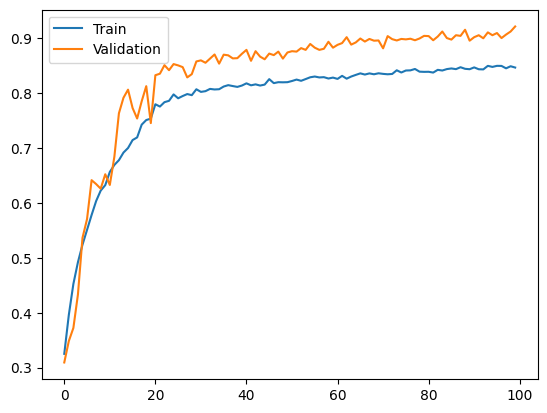

In [14]:
plt.plot(hist.history["accuracy"], label = "Train")
plt.plot(hist.history["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

In [16]:
model_post = load_model(r"rutan_classification_2023-09-09.hdf5")

In [20]:
model_post.evaluate(testGenerator)

149/149 [==============================] - 71s 473ms/step - loss: 0.2187 - accuracy: 0.9188


[0.21865107119083405, 0.9188052415847778]

In [21]:
imagen = load_img('bird.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - 0s 218ms/step
[[1.4363310e-01 8.7563787e-04 5.7189580e-04 8.5450387e-01 4.1555031e-04]]
Pez


In [22]:
imagen = load_img('cat.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - 0s 16ms/step
[[6.8765581e-01 3.3598166e-04 2.9659934e-05 3.1189728e-01 8.1272752e-05]]
Pájaro


In [23]:
imagen = load_img('dog.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - 0s 15ms/step
[[2.9998267e-01 3.3044959e-03 6.4316916e-01 6.1767822e-04 5.2925963e-02]]
Perro


In [24]:
imagen = load_img('fish.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - 0s 16ms/step
[[9.9903512e-01 5.7487890e-05 2.9950833e-04 5.9120316e-04 1.6695803e-05]]
Pájaro


In [25]:
imagen = load_img('wild.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - 0s 18ms/step
[[9.3029708e-01 8.1343707e-03 6.3302374e-04 4.8297018e-02 1.2638479e-02]]
Pájaro


## Tercer modelo

In [27]:
# Creamos un generador de imágenes para Training
trainImgGen = ImageDataGenerator(
    # Escalar los valores de las imágenes para que vayan entre 0 y 1
    rescale = 1. / 255,
    # Rotación de 40°
    rotation_range = 40,
    # Movimiento horizontal
    width_shift_range = 0.6,
    # Movimiento vertical
    height_shift_range = 0.35,
    # Cortar
    shear_range = 0.2,
    # Zoom
    zoom_range = 0.2,
    # Rotación horizontal
    horizontal_flip = True,
    # Rotación vertical
    vertical_flip = True,
    # Rellenar los espacios vacíos de la imagen al momento de transformarla
    fill_mode = "nearest",
    # Cambiar el brillo
    brightness_range = [0.2, 1.8],
    # Cambia el color de los canales
    channel_shift_range = 10.0      
)

# Creamos un generador de imágenes para Test y Validation simplemente escalando los valores para que vayan de 0 a 1
testDataGen = ImageDataGenerator(rescale = 1. / 255)

In [28]:
# Generamos imágenes para training cargándolas de un directorio
trainGenerator = trainImgGen.flow_from_directory(r"dataset/train",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 32 imágenes
    batch_size = 32,
    # Clasificación múltiples
    class_mode = "categorical"
)

# Generamos imágenes para validation cargándolas de un directorio y solamente reescalándolas
validationGenerator = testDataGen.flow_from_directory(r"dataset/validation",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 32 imágenes
    batch_size = 32,
    # Clasificación múltiples
    class_mode = "categorical"
)

# Generamos imágenes para testing cargándolas de un directorio y solamente reescalándolas
testGenerator = testDataGen.flow_from_directory(r"dataset/test",
    # Tamaño de las imágenes
    target_size = (128, 128),
    # Paquetes de a 32 imágenes
    batch_size = 32,
    # Clasificación múltiples
    class_mode = "categorical"
)

Found 13863 images belonging to 5 classes.
Found 2509 images belonging to 5 classes.
Found 4754 images belonging to 5 classes.


In [4]:
checkpoint = ModelCheckpoint(
    # Nombre del archivo. La extensión hdf5 es usada para guardar los pesos del modelo
    filepath = f"rutan_classification_{str(datetime.date.today())}.hdf5",
    verbose = 1,
    # Métrica que queremos monitorear
    monitor = "val_accuracy",
    # Solo guardar los mejores pesos
    save_best_only = True
)
# callback para reducir la tasa de aprendizaje si la métrica de validación deja de mejorar
reduce_lr = ReduceLROnPlateau(
    monitor = "val_loss", 
    factor = 0.2, 
    patience = 5, 
    min_lr = 0.00001
)

In [5]:
# Creamos un modelo secuencial
model = Sequential()

"""
Capa de entrada
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 16 kernels
        filters = 16, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
        # Datos de entrada de 128 pixeles con 3 canales
        input_shape = (128, 128, 3)
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))

"""
Capa de convolución 2
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 32 kernels
        filters = 32, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.2
model.add(Dropout(0.2))

"""
Capa de convolución 3
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 64 kernels
        filters = 64, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.3
model.add(Dropout(0.2))

"""
Capa de convolución 4
"""
# Agregamos una capa de convolución
model.add(Conv2D(
        # 128 kernels
        filters = 128, 
        # Kernels de 3x3
        kernel_size = (3, 3),
        # Agregamos un padding para que las imágenes después del kernel tengan el mismo tamaño que las de entrada
        padding = "same",
        # Función de activación ReLu
        activation = "relu",
        # Utilizamos regularización Ridge con peso de 1e-5
        kernel_regularizer = regularizers.l2(1e-5),
    )
)
# Apilamos una capa de Batch Normalization
model.add(BatchNormalization())
# Apilamos una capa de MaxPooling para eliminar ruido de tamaño 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.4
model.add(Dropout(0.3))

"""
Capa de salida
"""
# Agregamos una capa Flatten para aplanar los datos y que queden en una sola dimensión
model.add(Flatten())
# Agregamos una capa de Dropout para vigilar el Overfitting; la probabilidad de drop será de 0.5
model.add(Dropout(0.4))
# Agregamos una capa Densa con 256 neuronas y activación ReLu
model.add(Dense(256, activation = "relu"))
# Agregamos la capa encargada de la clasificación múltiple con activación Softmax
model.add(Dense(5, activation = "softmax"))

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                        

In [6]:
model.compile(
    # Función de pérdida Categorical Cross Entropy
    loss = "categorical_crossentropy",
    # Como optimizador utilizamos Adam que combina las bondades de AdaGrad y RMSProp
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    # Como métrica utilizamos el Accuracy Score
    metrics = "accuracy"
)

In [7]:
# Entrenamos el modelo con nuestro Data Generator
hist = model.fit(
    # Utiliza las imágenes generadas por el Train Generator
    trainGenerator,
    # Utilizar los callbacks que creamos
    callbacks = [checkpoint, reduce_lr],
    # Pasos por épocas igual a la cantidad de imágenes para training divido el tamaño de los batches
    #steps_per_epoch = 2600 // 64,
    # Entrenamos por 100 épocas
    epochs = 100,
    # Para validación utilizamos las imágenes generadas por el Validation Generator
    validation_data = validationGenerator,
    # Pasos para validación igual a la cantidad de imágenes para testing divido el tamaño de los batches
    #validation_steps = 930 // 64,
    verbose = 2,
    # Mezclar los datos
    shuffle = True
)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.37943, saving model to rutan_classification_2023-09-10.hdf5
434/434 - 320s - loss: 1.7726 - accuracy: 0.3198 - val_loss: 1.8281 - val_accuracy: 0.3794 - lr: 1.0000e-04 - 320s/epoch - 737ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.37943 to 0.41132, saving model to rutan_classification_2023-09-10.hdf5
434/434 - 55s - loss: 1.4086 - accuracy: 0.3809 - val_loss: 1.3228 - val_accuracy: 0.4113 - lr: 1.0000e-04 - 55s/epoch - 127ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.41132 to 0.47828, saving model to rutan_classification_2023-09-10.hdf5
434/434 - 55s - loss: 1.3432 - accuracy: 0.4218 - val_loss: 1.2003 - val_accuracy: 0.4783 - lr: 1.0000e-04 - 55s/epoch - 126ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.47828 to 0.52571, saving model to rutan_classification_2023-09-10.hdf5
434/434 - 55s - loss: 1.2725 - accuracy: 0.4593 - val_loss: 1.1448 - val_accuracy: 0.5257 - lr: 1.0000e-04 - 55s/epoc

* A cada convolución se le dividió por 2 el número de kernels
* Se eliminó la capa de convolución con 256 kernels
* Se eliminó la capa densa con 512 neuronas

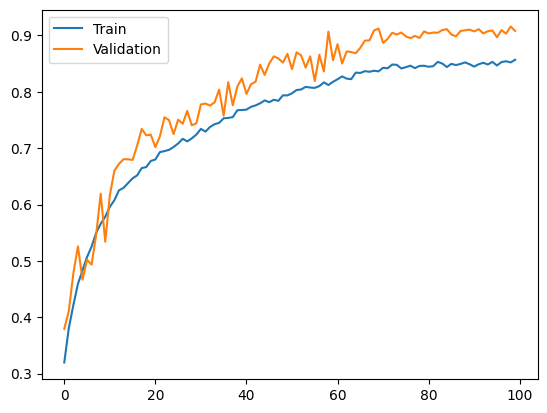

In [8]:
plt.plot(hist.history["accuracy"], label = "Train")
plt.plot(hist.history["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

In [29]:
model_post = load_model(r"rutan_classification_2023-09-10.hdf5")

In [30]:
model_post.evaluate(testGenerator)

149/149 [==============================] - 9s 54ms/step - loss: 0.2144 - accuracy: 0.9222


[0.21444007754325867, 0.9221708178520203]

In [36]:
imagen = load_img('bird.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step
[[9.7464097e-01 8.4308052e-04 2.1185563e-03 2.0345416e-02 2.0521113e-03]]
Pájaro


In [37]:
imagen = load_img('cat.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - 0s 15ms/step
[[8.7861309e-08 9.9998355e-01 1.4714254e-05 1.3774342e-06 2.3204420e-07]]
Gato


In [38]:
imagen = load_img('dog.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - 0s 16ms/step
[[2.8780016e-06 8.6525446e-03 9.7565722e-01 4.2323238e-05 1.5645128e-02]]
Perro


In [39]:
imagen = load_img('fish.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - 0s 16ms/step
[[1.2123559e-03 2.5261907e-04 4.6496384e-06 9.9840933e-01 1.2102085e-04]]
Pez


In [40]:
imagen = load_img('wild.jpg', target_size=(128, 128))

imagen = img_to_array(imagen)
imagen = imagen.reshape((1, imagen.shape[0], imagen.shape[1], imagen.shape[2]))
imagen /= 255.

prediccion = model_post.predict(imagen)
print(prediccion)
print(clases[np.argmax(prediccion)])

1/1 [==============================] - 0s 18ms/step
[[5.9411931e-03 2.3945041e-02 5.2808360e-03 6.5415379e-06 9.6482641e-01]]
Salvaje
